<a href="https://colab.research.google.com/github/JotaBlanco/TheValley/blob/main/Arboles/Clase_03_Arboles/03C_%7C_Introducci%C3%B3n_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 INTRO: Random Forest
Introducción a modelos de bagging de árboles de decisión (Random Forests).

Notebook por [Javier Blanco Cordero](https://www.linkedin.com/in/javier-blanco-cordero-71373656/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/1jRg7Dk2y_2_fxnC_Jpj5aWcqgW9t1KAd7izdmWzv9Sk/edit?usp=sharing)
*   [Enlace a este notebook](https://colab.research.google.com/github/JotaBlanco/TheValley/blob/main/Arboles/Clase_03_Arboles/03A_%7C_Repaso_I_sobre_%C3%81rboles_Decisi%C3%B3n.ipynb)




## 0101 Qué es un Random Forest?
Es una agregación de árboles de decisión de tipo bagging.

## 0102 Import
Importamos todas las librerías necesarias para este análisis ([¿No sabes lo que es una librería de Python?](https://www.quora.com/What-is-a-Python-library-and-what-can-I-use-it-for)): pandas, numpy, seaborn, matplotlib.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score

## 0103 Carga el dataset del Titanic
Volvamos con el Dataset del Titanic

Vamos a comparar el rendimiento de un Random Forest con los modelos de árboles de decisión que creamos en el [notebook 3B](https://colab.research.google.com/github/JotaBlanco/TheValley/blob/main/Arboles/Clase_03_Arboles/03B_%7C_Repaso_II_sobre_%C3%81rboles_Decisi%C3%B3n.ipynb).

Este es el link al archivo raw: https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/titanic.csv.

Importa los datos en un dataframe llamado **dataframe df_titanic**.

In [101]:
# Url archivo raw
url = 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/titanic.csv'

# Importa csv
df_titanic = pd.read_csv(url)

# Visualización primeras filas
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 0104 Limpieza del Dataset
Limpiamos los nulos y creamos la variable Title como en el notebook 3B.

In [102]:
# Creamos una nueva variable Título (es opcional, pero podría ayudar al modelo)
df_titanic['Title'] = [name.split(",")[1].split(".")[0][1:] for name in df_titanic['Name']]
df_titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs


In [103]:
# Columnas con las que nos quedamos
cols = ['Survived', 
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']

# De ellas, cuáles son categóricas
cat_cols = ['Sex', 'Embarked', 'Title']

# Visualizamos las columnas con las que nos hemos quedado
df_titanic[cols].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [104]:
# Rellenamos los nulos de las variables numéricas (edad)
df_titanic[cols].isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Title         0
dtype: int64

In [105]:
# Rellenamos los nulos de la variable edad de una forma avanzada:
# calculando la media para cada título

filtro_edad_nula = df_titanic['Age'].isna()
filtro_edad_no_nula = df_titanic['Age'].notnull()

# Rellenamos los nulos en función del título 
for titulo in df_titanic['Title'].unique():
  filtro_titulo = df_titanic['Title'] == titulo

  if len(df_titanic[((filtro_titulo) & (filtro_edad_no_nula))]) > 2:
    print(titulo)
    df_titanic.loc[((filtro_titulo)&(filtro_edad_nula)), 'Age'] = df_titanic.loc[((filtro_titulo)&(filtro_edad_no_nula)), 'Age'].median()
  
# Rellenamos los que sigan siendo nulos (títulos solo presentes entre gente sin la edad informada)
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].median())

Mr
Mrs
Miss
Master
Rev
Dr


In [106]:
# Eliminamos los nulos de la variable Embarked
print(len(df_titanic))
df_titanic = df_titanic.dropna(subset=['Embarked'])
print(len(df_titanic))

891
889


In [107]:
# Dumificamos variables categóricas
df_titanic_i = pd.get_dummies(df_titanic[cols], 
                              prefix_sep='_',
                              drop_first=True, 
                              columns=cat_cols)
df_titanic_i.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Col,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0,3,22.0,1,0,7.2500,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## 0105 Train-Test Split

In [108]:
# Generamos las matrices X e y
X_titanic = df_titanic_i.drop('Survived',axis=1)
y_titanic = df_titanic_i['Survived']

X_titanic.shape, y_titanic.shape

((889, 24), (889,))

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic, 
                                                    y_titanic, 
                                                    test_size=0.25, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((666, 24), (223, 24), (666,), (223,))

# 02 Entrenamiento árbol de decisión
Entrenamos un árbol de decisión tomando medidas para evitar el overfitting.

In [110]:
from sklearn.metrics import roc_auc_score

In [111]:
def entrenar_modelo_y_predecir_classificacion(modelo):
  # Entreno el árbol con el set de entrenamiento
  modelo = modelo.fit(X=X_train, y=y_train)
  # Uso el árbol para predecir sobre el dataset de entrenamiento
  y_pred_train = modelo.predict(X_train)
  # Uso el árbol para predecir sobre el dataset de test
  y_pred_test = modelo.predict(X_test)
  # Cómo de buena es la predicción?
  ac_train = round(accuracy_score(y_train, y_pred_train), 4)
  print('Precisión en set de entrenamiento :', ac_train)
  ac_test = round(accuracy_score(y_test, y_pred_test), 4)
  print('Precisión en set de test :', ac_test)
  print('Degradación: ', round((ac_train-ac_test)/ac_train*100,2), '%')
  print('ROC AUC: ', round(roc_auc_score(y_test, y_pred_test),2))

In [112]:
modelo = tree.DecisionTreeClassifier(max_depth=20, 
                                     min_samples_split = 20,
                                     min_samples_leaf = 5, 
                                     min_impurity_decrease = 0.003)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8589
Precisión en set de test : 0.843
Degradación:  1.85 %
ROC AUC:  0.82


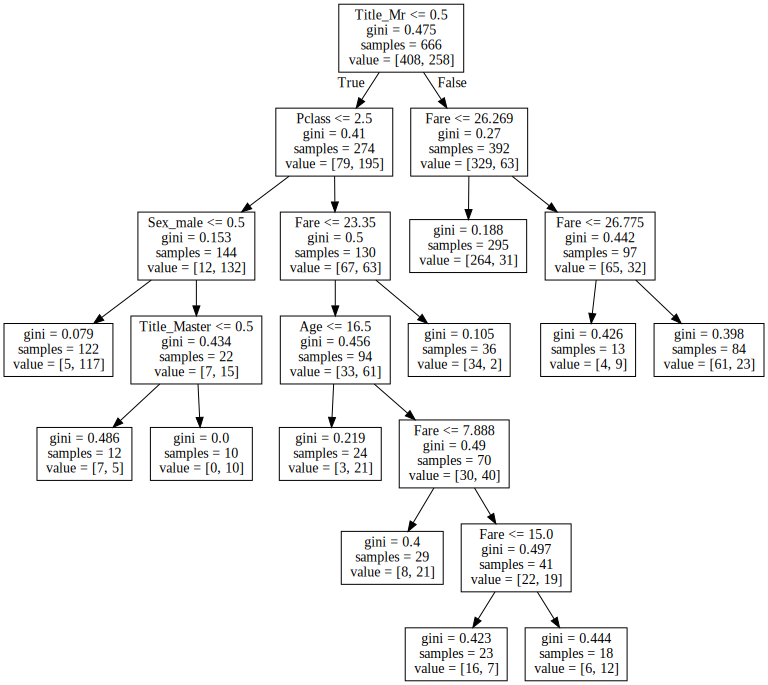

In [114]:
# con export_graphviz
dot_data = tree.export_graphviz(modelo, 
                                out_file=None, 
                                feature_names=list(X_titanic.columns)) 
graph = graphviz.Source(dot_data) 
graph

# 03 Entrenamiento Random Forest
Ahora comparamos el rendimiento del árbol de decisión con un Random Forest.
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [115]:
# Importamos el modelo desde Sklearn
from sklearn import ensemble

In [142]:
modelo = ensemble.RandomForestClassifier(n_estimators = 200,
                                         max_depth = 3, 
                                         min_samples_split = 10,
                                         min_samples_leaf = 5)

# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8243
Precisión en set de test : 0.8206
Degradación:  0.45 %
ROC AUC:  0.81


In [150]:
modelo = ensemble.RandomForestClassifier(n_estimators = 250,
                                         max_features = "auto",
                                         max_depth = 5, 
                                         min_samples_split = 5,
                                         min_samples_leaf = 3)

# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8544
Precisión en set de test : 0.8072
Degradación:  5.52 %
ROC AUC:  0.79


# 04 EJERCICIO


## 0401 Importa Dataset Diabetes
Vamos a utilizar el dataset del notebook 3A (Diabetes).

Impórtalo utilizando el archivo raw: 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/diabetesIndia.csv'.

Guárdalo en el **dataframe df**.

In [99]:
url = 'https://raw.githubusercontent.com/JotaBlanco/TheValley/main/Data/diabetesIndia.csv'

df = pd.read_csv(url)

df.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


## 0402 Limpia el dataset
Comprueba el dataset (hay nulos) y prepáralo si es necesario.

In [151]:
# Rellenamos los nulos de las variables numéricas (edad)
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 0403 Train-Test split
Genera el set de pruebas (test).

In [152]:
# Generamos las matrices X e y
X = df.drop('Outcome',axis=1)
y = df['Outcome']

X.shape, y.shape

((768, 8), (768,))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((576, 8), (192, 8), (576,), (192,))

## 0404 Árbol de Decisión
Encuentra el mejor árbol de decisión posible

In [157]:
modelo = tree.DecisionTreeClassifier(max_depth=15, 
                                     min_samples_split = 20,
                                     min_samples_leaf = 10, 
                                     min_impurity_decrease = 0.005)
# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.8056
Precisión en set de test : 0.75
Degradación:  6.9 %
ROC AUC:  0.71


## 0405 Random Forest
Encuentra el mejor modelo de rándom forest posible.

In [171]:
modelo = ensemble.RandomForestClassifier(n_estimators = 500,
                                         max_features = "auto",
                                         max_depth = 3, 
                                         min_samples_split = 20,
                                         min_samples_leaf = 5, 
                                         min_impurity_decrease = 0.005)

# Entrenamos y predecimos con dicho modelo
entrenar_modelo_y_predecir_classificacion(modelo)

Precisión en set de entrenamiento : 0.783
Precisión en set de test : 0.7604
Degradación:  2.89 %
ROC AUC:  0.71
